In [98]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [99]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import re
from pathlib import Path
from typing import List
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

from pydantic import BaseModel, Field

from typing import TypedDict, List, Any, Optional, Dict
from typing import Annotated, Literal
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage


In [100]:
OPEN_API_KEY = os.getenv('OPEN_API_KEY')

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')

TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [101]:

llm = ChatOpenAI(model="gpt-4o", temperature=0)

Tools added:
- Tavily search tool
    - Task: Get the URLs, content, and title of where the dataset is located.
    - Input: A user query
    - Output: A TavilySearchOutput consisting of URLs, Title, Content
- Download Kaggle Files
    - Task: Download each Kaggle dataset URL into its own folder and return structured bundles for UI/analysis.
    - Input: Output from Tavily Search Tool (TavilySearchOutput)
    - Output: A list of DownloadedDataset objects, each containing:
        - source_url: The original Kaggle dataset URL
        - source_id: The Kaggle dataset identifier (e.g., "username/dataset-name")
        - display_name: (Optional) A human-readable name for the dataset
        - dest_dir: The local directory where the dataset was downloaded
        - files: A list of FileRecord objects for each file downloaded, with path, rel_path, and ext
        - meta: Additional metadata (e.g., download status, errors, timestamps)

In [102]:
# Initialize Tavily client
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

In [ ]:
# Agent
class TavilySearchOutput(BaseModel):
    title: str
    url: str
    content: str

class FileRecord(BaseModel):
    path: str
    rel_path: str
    ext: str
    name: Optional[str] = None
    size_bytes: Optional[int] = None

class DownloadedDataset(BaseModel):
    source_url: str
    source_id: str
    display_name: Optional[str] = None
    dest_dir: str
    files: List[FileRecord]
    meta: Dict[str, Any] = Field(default_factory=dict)

# Analysis models
class ColumnSummary(BaseModel):
    name: str
    dtype: str
    num_non_null: Optional[int] = None
    num_null: Optional[int] = None
    num_unique: Optional[int] = None
    sample_values: List[Any] = Field(default_factory=list)
    numeric_summary: Optional[Dict[str, float]] = None  # mean, std, min, max, percentiles
    categorical_top_values: Optional[List[tuple]] = None  # [(value, count), ...]

class FileAnalysis(BaseModel):
    file_path: str
    rel_path: str
    ext: str
    num_rows: Optional[int] = None
    num_columns: Optional[int] = None
    columns: List[ColumnSummary] = Field(default_factory=list)
    memory_usage_bytes: Optional[int] = None
    head_preview: List[Dict[str, Any]] = Field(default_factory=list)
    notes: List[str] = Field(default_factory=list)

class DatasetAnalysisOutput(BaseModel):
    summary: str = Field(description="A concise 5 pointer summary in bullet points")
    possibilities: Literal["classification", "regression", "clustering", "time_series", "text_generation", "image_generation", "other"] = Field(description="The best way to use the dataset")
    potential_reasons: List[str] = Field(description="Potential reasons for using the dataset as classified in the possibilities field")


class DatasetAnalysis(BaseModel):
    source_url: str
    source_id: str
    display_name: Optional[str] = None
    dest_dir: str
    files: List[FileAnalysis] = Field(default_factory=list)
    aggregate_stats: Dict[str, Any] = Field(default_factory=dict)
    ai_summary: Optional[DatasetAnalysisOutput] = None
    links: List[TavilySearchOutput] = Field(default_factory=list)

class AgentState(TypedDict):
    query: str
    tavilySearchOutput: List[TavilySearchOutput]
    status: Annotated[List[str], add]
    download_results: Annotated[List[DownloadedDataset], add]
    dataset_analyses: Annotated[List[DatasetAnalysis], add]


In [112]:
# This function takes your search term, looks it up on dataset-heavy sites, filters duplicates, and returns a clean list of dataset pages.

def tavily_search_tool(state: AgentState):
    """Search Kaggle only and return up to 10 most relevant, deduped dataset links."""
    query = state["query"]

    site_queries = {
        "kaggle": f"{query} dataset site:kaggle.com/datasets"
    }

    def which_site(url: str) -> str | None:
        u = url.lower()
        if "kaggle.com/datasets/" in u:
            return "kaggle"
        return None

    def relevance_score(site: str, title: str, url: str, content: str) -> float:
        t = (title or "").lower()
        u = (url or "").lower()
        c = (content or "").lower()
        score = 0.0
        if any(x in u for x in [".csv", ".xlsx", ".json", "/download", "/raw/"]):
            score += 3.0
        if any(x in c for x in ["csv", "xlsx", "json", "download"]):
            score += 2.0
        for tok in set(query.lower().split()):
            if tok and (tok in t or tok in c):
                score += 0.5
        if site == "kaggle":
            score += 0.5
        return score

    candidates: list[tuple[str, TavilySearchOutput, float]] = []
    seen_urls: set[str] = set()

    # Collect per-site, compute scores (Kaggle only)
    for site, q in site_queries.items():
        try:
            r = tavily_client.search(query=q, search_depth="basic", max_results=15)
        except Exception:
            continue
        if not isinstance(r, dict) or "results" not in r:
            continue
        for h in r["results"]:
            url = h.get("url", "") if isinstance(h, dict) else ""
            site_name = which_site(url) if url else None
            if site_name is None:
                continue
            if url in seen_urls:
                continue
            seen_urls.add(url)
            title = h.get("title", "")
            content = h.get("content", "")
            tso = TavilySearchOutput(title=title, url=url, content=content)
            score = relevance_score(site_name, title, url, content)
            candidates.append((site_name, tso, score))

    candidates.sort(key=lambda x: x[2], reverse=True)

    selected: list[TavilySearchOutput] = []
    used_urls: set[str] = set()

    for _, tso, _ in candidates:
        if len(selected) >= 10:
            break
        if tso.url in used_urls:
            continue
        selected.append(tso)
        used_urls.add(tso.url)

    return { "tavilySearchOutput": selected, "status": ["Gathered Kaggle urls"] }

# Get datasest from Kaggle

## Tool to download Kaggle Files: download_kaggle_files

In [ ]:
def download_kaggle_files(state: AgentState, data_dir: str = './data') -> dict:
    """
    Download each Kaggle URL into its own folder and return structured bundles for UI/analysis.
    """

    urls = [tso.url for tso in state['tavilySearchOutput']]

    api = KaggleApi()
    api.authenticate()

    base_dir = Path(data_dir) / 'kaggle'
    base_dir.mkdir(parents=True, exist_ok=True)

    def sanitize_slug(slug: str) -> str:
        # 'owner/name' -> 'owner__name' and strip unsafe chars
        return re.sub(r'[^a-zA-Z0-9._-]+', '_', slug.replace('/', '__'))

    bundles: List[DownloadedDataset] = []

    for url in urls:
        # Extract dataset slug from URL
        m = re.search(r'kaggle\.com/datasets/([^/]+/[^/?#]+)', url)
        if not m:
            continue
        slug = m.group(1)
        owner = slug.split('/')[0]
        name = slug.split('/')[-1]

        dest_dir = base_dir / sanitize_slug(slug)
        dest_dir.mkdir(parents=True, exist_ok=True)

        api.dataset_download_files(
            slug,
            path=str(dest_dir),
            force=False,
            quiet=True,
            unzip=True
        )

        files: List[FileRecord] = []
        for p in dest_dir.rglob('*'):
            if p.is_file():
                try:
                    size = p.stat().st_size
                except Exception:
                    size = 0
                files.append(FileRecord(
                    path=str(p.resolve()),
                    rel_path=str(p.relative_to(dest_dir)),
                    ext=p.suffix.lower(),
                    name=p.name,
                    size_bytes=int(size) if size is not None else None,
                ))

        bundles.append(DownloadedDataset(
            source_url=url,
            source_id=slug,
            display_name=name,
            dest_dir=str(dest_dir.resolve()),
            files=files,
            meta={
                'owner': owner,
                'num_files': len(files),
            }
        ))

    return {"download_results": bundles, "status": ["Downloaded Kaggle bundles"]}

In [116]:
# Analysis utilities and tool
import json
import pandas as pd
import numpy as np
from collections import Counter
from pathlib import Path
from datetime import datetime


def to_json_safe(obj):
    if obj is None:
        return None
    try:
        import numpy as _np
        import pandas as _pd
    except Exception:
        _np = None
        _pd = None
    # numpy scalars
    if _np is not None and isinstance(obj, (_np.integer,)):
        return int(obj)
    if _np is not None and isinstance(obj, (_np.floating,)):
        if _np.isnan(obj):
            return None
        return float(obj)
    if _np is not None and isinstance(obj, (_np.bool_,)):
        return bool(obj)
    # pandas timestamps/timedeltas
    if _pd is not None and isinstance(obj, _pd.Timestamp):
        return obj.isoformat()
    if isinstance(obj, datetime):
        return obj.isoformat()
    if _pd is not None and isinstance(obj, _pd.Timedelta):
        return str(obj)
    # pandas containers
    if _pd is not None and isinstance(obj, _pd.Series):
        return to_json_safe(obj.tolist())
    if _pd is not None and isinstance(obj, _pd.DataFrame):
        return to_json_safe(obj.to_dict(orient="records"))
    # generic containers
    if isinstance(obj, dict):
        return {str(k): to_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [to_json_safe(v) for v in obj]
    return obj

PERCENTILES = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]


def summarize_numeric_series(s: pd.Series) -> dict:
    s_numeric = pd.to_numeric(s, errors='coerce')
    desc = s_numeric.describe(percentiles=PERCENTILES, include='all')
    summary = {
        "count": int(desc.get("count", 0) or 0),
        "mean": float(desc.get("mean", np.nan)) if not pd.isna(desc.get("mean", np.nan)) else None,
        "std": float(desc.get("std", np.nan)) if not pd.isna(desc.get("std", np.nan)) else None,
        "min": float(desc.get("min", np.nan)) if not pd.isna(desc.get("min", np.nan)) else None,
        "25%": float(desc.get("25%", np.nan)) if not pd.isna(desc.get("25%", np.nan)) else None,
        "50%": float(desc.get("50%", np.nan)) if not pd.isna(desc.get("50%", np.nan)) else None,
        "75%": float(desc.get("75%", np.nan)) if not pd.isna(desc.get("75%", np.nan)) else None,
        "max": float(desc.get("max", np.nan)) if not pd.isna(desc.get("max", np.nan)) else None,
    }
    # Add extra percentiles
    for p in PERCENTILES:
        key = f"p{int(p*100)}"
        try:
            val = np.nanpercentile(s_numeric.to_numpy(dtype=float), p*100)
            summary[key] = float(val)
        except Exception:
            summary[key] = None
    return summary


def summarize_categorical_series(s: pd.Series, top_k: int = 10) -> list:
    vc = s.astype(str).value_counts(dropna=False).head(top_k)
    return [(idx, int(cnt)) for idx, cnt in vc.items()]


def sample_values(s: pd.Series, k: int = 5) -> list:
    try:
        uniq = s.dropna().unique()
        values = uniq.tolist() if hasattr(uniq, "tolist") else list(uniq)
    except Exception:
        # Fallback for unhashable types (e.g., dicts in cells)
        try:
            values = s.dropna().astype(str).unique().tolist()
        except Exception:
            values = []
    if not isinstance(values, list):
        values = list(values)
    np.random.shuffle(values)
    return values[:k]


def read_tabular_file(file_path: str, ext: str) -> pd.DataFrame | None:
    try:
        # Normalize extension including compressed variants
        lower_path = file_path.lower()
        is_gz = lower_path.endswith('.gz') or lower_path.endswith('.gzip')
        is_zip = lower_path.endswith('.zip')
        base_ext = ext
        if is_gz and base_ext == '.gz':
            # Guess inner extension from name without .gz
            if lower_path.endswith('.csv.gz'):
                base_ext = '.csv'
            elif lower_path.endswith('.json.gz'):
                base_ext = '.json'
        if base_ext == ".csv":
            # Robust CSV read attempts
            for kwargs in (
                {"low_memory": False},
                {"low_memory": False, "encoding": "utf-8"},
                {"low_memory": False, "encoding": "latin-1"},
                {"low_memory": False, "on_bad_lines": "skip"},
            ):
                try:
                    return pd.read_csv(file_path, **kwargs)
                except Exception:
                    continue
            return None
        if base_ext in {".xlsx", ".xls"}:
            try:
                return pd.read_excel(file_path, engine=None)
            except Exception:
                try:
                    return pd.read_excel(file_path, engine="openpyxl")
                except Exception:
                    return None
        if base_ext == ".json":
            # Try to read JSON lines or standard JSON
            try:
                return pd.read_json(file_path, lines=True)
            except ValueError:
                try:
                    return pd.read_json(file_path)
                except Exception:
                    return None
        # Unsupported tabular
        return None
    except Exception:
        return None


def analyze_dataframe(df: pd.DataFrame) -> tuple[list[ColumnSummary], dict, int, int, list, int]:
    num_rows = int(df.shape[0])
    num_cols = int(df.shape[1])
    memory_usage_bytes = int(df.memory_usage(deep=True).sum())
    preview = df.head(10).to_dict(orient="records")

    columns: list[ColumnSummary] = []
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        non_null = int(s.notnull().sum())
        nulls = int(s.isnull().sum())
        # Robust nunique handling for unhashable mixed types
        try:
            nunique = int(s.nunique(dropna=True))
        except TypeError:
            try:
                nunique = int(s.astype(str).nunique(dropna=True))
            except Exception:
                nunique = None
        col_summary = ColumnSummary(
            name=str(col),
            dtype=dtype,
            num_non_null=non_null,
            num_null=nulls,
            num_unique=nunique,
            sample_values=sample_values(s, 5),
        )
        if pd.api.types.is_numeric_dtype(s):
            col_summary.numeric_summary = summarize_numeric_series(s)
        else:
            col_summary.categorical_top_values = summarize_categorical_series(s)
        columns.append(col_summary)

    aggregate_stats = {
        "num_rows": num_rows,
        "num_columns": num_cols,
        "memory_usage_bytes": memory_usage_bytes,
        "column_types": Counter([c.dtype for c in columns]),
    }

    return columns, aggregate_stats, num_rows, num_cols, preview, memory_usage_bytes



def ai_generate_dataset_summary(llm: ChatOpenAI, analysis: DatasetAnalysis) -> DatasetAnalysisOutput:
    try:
        sys = SystemMessage(content=(
            "You are a data analysis assistant. Summarize the dataset for a product UI. "
            "Be concise, cover key columns, row/column counts, notable distributions, data quality notes, and potential uses."
        ))
        content = {
            "name": analysis.display_name,
            "source_id": analysis.source_id,
            "num_files": len(analysis.files),
            "aggregate_stats": analysis.aggregate_stats,
            "files": [
                {
                    "rel_path": f.rel_path,
                    "ext": f.ext,
                    "num_rows": f.num_rows,
                    "num_columns": f.num_columns,
                } for f in analysis.files
            ],
        }
        user = HumanMessage(content=f"Summarize this dataset for UI: {json.dumps(content)[:12000]}")
        resp = llm.with_structured_output(DatasetAnalysisOutput).invoke([sys, user])
        return resp.content if isinstance(resp, AIMessage) else str(resp)
    except Exception:
        return None


def analyze_downloaded_datasets(state: AgentState, analyses_dir: str = "./data/analyses", generate_ai_summary: bool = True) -> dict:
    analyses_path = Path(analyses_dir)
    analyses_path.mkdir(parents=True, exist_ok=True)

    results: list[DatasetAnalysis] = []

    for bundle in state.get("download_results", []):
        # Pick relevant links for this dataset (match by exact URL or by slug inside URL)
        slug = bundle.source_id.lower()
        relevant_links = []
        for tso in state.get("tavilySearchOutput", []):
            u = (tso.url or "").lower()
            if u == (bundle.source_url or "").lower() or slug in u:
                relevant_links.append(tso)

        ds_analysis = DatasetAnalysis(
            source_url=bundle.source_url,
            source_id=bundle.source_id,
            display_name=bundle.display_name,
            dest_dir=bundle.dest_dir,
            links=relevant_links,
        )

        for fr in bundle.files:
            ext = fr.ext.lower()
            # Allow compressed tabular files
            supported_exts = {".csv", ".xlsx", ".xls", ".json", ".gz"}
            if ext not in supported_exts:
                continue
            # Skip empty files
            if getattr(fr, "size_bytes", None) == 0:
                ds_analysis.files.append(FileAnalysis(
                    file_path=fr.path,
                    rel_path=fr.rel_path,
                    ext=fr.ext,
                    notes=["File is empty"],
                ))
                continue
            df = read_tabular_file(fr.path, ext)
            if df is None or df.shape[0] == 0:
                fa = FileAnalysis(
                    file_path=fr.path,
                    rel_path=fr.rel_path,
                    ext=fr.ext,
                    notes=["Unsupported, unreadable, or empty tabular file"],
                )
                ds_analysis.files.append(fa)
                continue

            columns, agg, nrows, ncols, preview, mem_bytes = analyze_dataframe(df)
            fa = FileAnalysis(
                file_path=fr.path,
                rel_path=fr.rel_path,
                ext=fr.ext,
                num_rows=nrows,
                num_columns=ncols,
                columns=columns,
                memory_usage_bytes=mem_bytes,
                head_preview=preview,
            )
            ds_analysis.files.append(fa)

        # Aggregate over files
        total_rows = sum((f.num_rows or 0) for f in ds_analysis.files if f.num_rows is not None)
        columns_list = [f.num_columns or 0 for f in ds_analysis.files if f.num_columns is not None]
        total_columns = max(columns_list) if columns_list else 0
        total_memory = sum((f.memory_usage_bytes or 0) for f in ds_analysis.files if f.memory_usage_bytes is not None)
        ds_analysis.aggregate_stats = {
            "total_rows": int(total_rows),
            "max_columns": int(total_columns),
            "total_memory_usage_bytes": int(total_memory),
            "num_files_analyzed": int(len(ds_analysis.files)),
        }

        if generate_ai_summary:
            ds_analysis.ai_summary = ai_generate_dataset_summary(llm, ds_analysis)

        # Persist as JSON for UI
        out_name = f"{bundle.source_id.replace('/', '__')}.analysis.json"
        out_path = analyses_path / out_name
        with open(out_path, "w", encoding="utf-8") as f:
            payload = ds_analysis.model_dump() if hasattr(ds_analysis, "model_dump") else ds_analysis.dict()
            json.dump(to_json_safe(payload), f, ensure_ascii=False, indent=2)

        results.append(ds_analysis)

    return {"dataset_analyses": results, "status": ["Analyzed datasets"]}


In [117]:
def end_agent(state: AgentState):
    return state


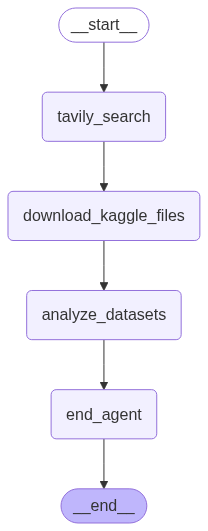

In [118]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)

graph.add_node("tavily_search", tavily_search_tool)
graph.add_node("download_kaggle_files", download_kaggle_files)
graph.add_node("analyze_datasets", analyze_downloaded_datasets)
graph.add_node("end_agent", end_agent)

graph.add_edge(START, "tavily_search")
graph.add_edge("tavily_search", "download_kaggle_files")
graph.add_edge("download_kaggle_files", "analyze_datasets")
graph.add_edge("analyze_datasets", "end_agent")

final_graph = graph.compile()

from IPython.display import Image, display
display(Image(final_graph.get_graph().draw_mermaid_png()))


In [119]:
query = "Sentiment analysis of the latest news on the stock market"

state = AgentState(query=query)


In [ ]:
for event in final_graph.stream(state):
    print(event)